# Project 1

In [2]:
% load data
P = load('data/p1_swanPolygon.txt');
x = P(:,1);
y = P(:,2);

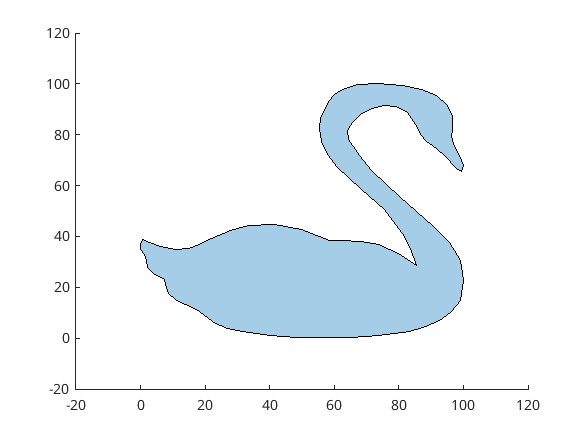

In [3]:
pgon = polyshape(x,y); % mainly for drawing
plot(pgon)

Here we use possion disc method to generate more uniform points.

In [4]:
pts = poissonDisc([100,100],2); % random points(possion disc method)
inside = isinterior(pgon, pts(:, 1), pts(:, 2));
pts = pts(inside,:); % filter
pts = [P;pts]; % combined

set constriants to limit delaunay generation

In [5]:
n = length(P);
C = [(1:n)' circshift((1:n)',-1)]; % limit delaunany Trigangulation inside the polygon

DT = delaunayTriangulation(pts,C);
IO = isInterior(DT);
kDT = DT.ConnectivityList(IO,:);
n = size(kDT,1);

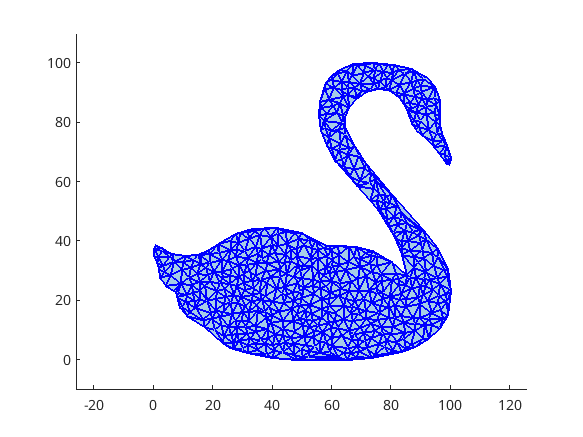

In [21]:
plot(pgon)
hold on

triplot(DT(IO,:),DT.Points(:,1),DT.Points(:,2),'LineWidth',2)
axis equal
hold off

The following discussion shall be based on only these two variables, the index (n) represents each triangle.

In [6]:
centroid_list = zeros(n,2); % (n,2)
area_list = zeros(n,1); % (n,1)

In [7]:
for i = 1:size(DT.ConnectivityList(IO,:),1)
    % Get the vertices of the triangle
    v1 = DT.Points(kDT(i,1),:);
    v2 = DT.Points(kDT(i,2),:);
    v3 = DT.Points(kDT(i,3),:);

    % Calculate and store the centroid
    centroid_list(i,:) = (v1 + v2 + v3)/3;

    % Calculate and store the area
    area_list(i) = abs((v1(1)*(v2(2)-v3(2)) + v2(1)*(v3(2)-v1(2)) + v3(1)*(v1(2)-v2(2)))/2);
end

We assume $y<20$ means underwater, and calculate that area & weighted_center to represent the force of buoyancy.

In [8]:
total_area = sum(area_list,1)
weighted_center = sum(centroid_list .* area_list,1) / total_area

under_water_part = find(centroid_list(:,2)<20);
under_water_area = sum(area_list(under_water_part,:),1)
tmp=(centroid_list .* area_list);
under_water_weighted_center = sum(tmp(under_water_part,:),1) / under_water_area

total_area = 4.2580e+03

weighted_center = 1x2 double
   58.1364   34.3349

under_water_area = 1.4569e+03

under_water_weighted_center = 1x2 double
   55.9928   11.3765

Visualization:

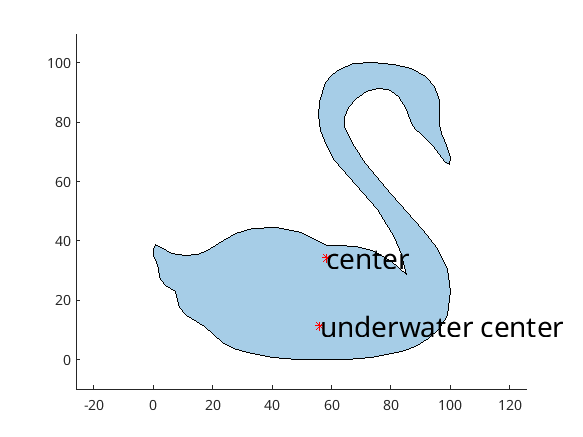

In [33]:
plot(pgon)
hold on

plot(weighted_center(1), weighted_center(2), 'r*');
text(weighted_center(1), weighted_center(2), 'center', 'FontSize',20);
plot(under_water_weighted_center(1), under_water_weighted_center(2), 'r*');
text(under_water_weighted_center(1), under_water_weighted_center(2), 'underwater center', 'FontSize',20);
axis equal
hold off

We can at least change the density to make gravity and buoyancy balanced, but since they are not aligned in x-axis, this way of floating is **not stable**.

In [9]:
density = under_water_area / (1.25 * total_area) % however this is still not stable since they don't have same axis.

density = 0.2737

Now comes the part when we discuss what is the best way fill the space with triangles.

We set the variable $x$ as filling rate of each triangle, limit it directly to $0.1 \to 0.9$, and solve the problem based on floating and stability(alignment on x-axis only)

In [36]:
x = zeros(n);
% limit: x > 0 && x < 1 -> x > 0.1 && x < 0.9
% (x .* centroid_list .* area_list)/sum(x .* area_list) == under_water_weighted_center
% x .* centroid_list .* area_list = under_water_weighted_center * under_water_area / 1.25
% sum(x .* area_list) * 1.25 == under_water_area
f = zeros(n, 1);

% Inequalities
% lower bound, -x <= -0.1, upper bound x <= 0.9
lb = 0.1 * ones(n, 1);
ub = 0.9 * ones(n, 1);
A = [];
b = [];

% Equalities
tmp = centroid_list(:,1) .* area_list;
Aeq = horzcat(tmp,area_list);
Aeq = transpose(Aeq);
tmp = under_water_weighted_center .* under_water_area ./ 1.25;
beq = [tmp(1),under_water_area / 1.25];
beq = transpose(beq);

opts = optimoptions('linprog','Algorithm','interior-point');
[x, fval] = linprog(f, A, b, Aeq, beq, lb, ub, opts);


Minimum found that satisfies the constraints.

Optimization completed because the objective function is non-decreasing in
feasible directions, to within the function tolerance, and constraints are
satisfied to within the constraint tolerance.



>If you change the above code to the following, you'll notice matlab can't solve the problem (both x & y axis matching)

In [35]:
x = zeros(n);
% limit: x > 0 && x < 1 -> x > 0.1 && x < 0.9
% (x .* centroid_list .* area_list)/sum(x .* area_list) == under_water_weighted_center
% x .* centroid_list .* area_list = under_water_weighted_center * under_water_area / 1.25
% sum(x .* area_list) * 1.25 == under_water_area
f = zeros(n, 1);

% Inequalities
% lower bound, -x <= -0.1, upper bound x <= 0.9
lb = 0.1 * ones(n, 1);
ub = 0.9 * ones(n, 1);
A = [];
b = [];

% Equalities
tmp = centroid_list .* area_list;
Aeq = horzcat(tmp(:,1),tmp(:,2),area_list);
Aeq = transpose(Aeq);
tmp = under_water_weighted_center .* under_water_area ./ 1.25;
beq = [tmp(1),tmp(2),under_water_area / 1.25];
beq = transpose(beq);

opts = optimoptions('linprog','Algorithm','interior-point');
[x, fval] = linprog(f, A, b, Aeq, beq, lb, ub, opts);


The problem is infeasible.

Linprog stopped because no point satisfies the constraints.



We then calculate the new center (with $x$ as filling rate)

In [11]:
new_center = sum(x .* centroid_list .* area_list, 1) / sum(x .* area_list, 1)

new_center = 1x2 double
   55.9928   33.6835

Visualization:

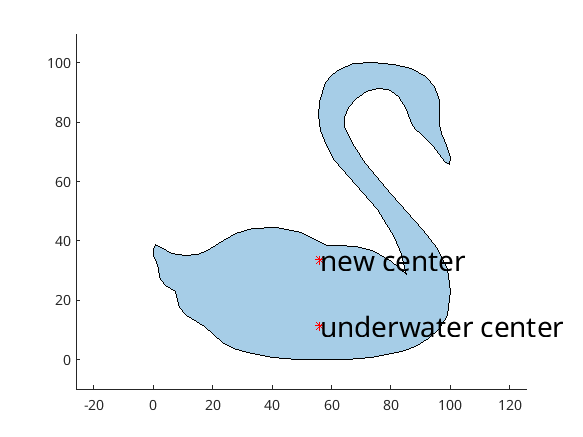

In [34]:
plot(pgon)
hold on

plot(under_water_weighted_center(1), under_water_weighted_center(2), 'r*');
text(under_water_weighted_center(1), under_water_weighted_center(2), 'underwater center', 'FontSize',20);
plot(new_center(1), new_center(2), 'r*');
text(new_center(1), new_center(2), 'new center', 'FontSize',20);

axis equal
hold off

Detailed filling rate:

In [40]:
transpose(x)

ans = 1x1129 double
    0.3378    0.3193    0.3167    0.3977    0.3024    0.3456    0.2985    0.2904    0.3005    0.1866    0.2275    0.2724    0.3451    0.3315    0.1558    0.2888    0.3032    0.2809    0.3011    0.2719    0.3037    0.2556    0.1973    0.2697    0.3230    0.3521    0.3902    0.3642    0.3137    0.3794
...

Changing materials/liquid density:

You can achieve this by modifying the 1.25 in code above, I'm skipping this part since it's not that interesting.

Floating in certain direction:

To achieve that you can modify the under_water_part (for example limit with $\cos \theta \cdot x + \sin \theta \cdot y < 20$ or something), that's all you need for it to float in certain direction.

Credit:

Bundled `poissonDisc.m` is the work of:

**Mohak Patel, Brown University, 2016**

Located at: https://github.com/mohakpatel/Poisson-Disc-Sampling MIT License, great thanks to him!